<br>

# Curate A Dataset

<br>

In [1]:
import datetime
import json
import math
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import time

from datetime import timedelta
# 3rd-part library for managing imbalanced data.
from imblearn.under_sampling import RandomUnderSampler
from IPython.core.interactiveshell import InteractiveShell

from sklearn.model_selection import RandomizedSearchCV, train_test_split
from tensorflow.keras.layers import Input, Dense, Embedding, Flatten, MaxPooling1D, BatchNormalization, Conv1D, GRU, LSTM
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD, Adam, RMSprop
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

In [49]:
%matplotlib inline

# Set dataframe options to keep long data in columns from being truncated with ellipsis (...)
pd.set_option('max_colwidth', None)

# Set dataframe options to force display max columns
pd.set_option('display.max_columns', 90)
pd.set_option('display.max_rows', 90)

InteractiveShell.ast_node_interactivity = "all"

Helper functions that is used throughout this notebook.  

In [5]:
def create_dataframe(file_path):
    '''
    Create a pandas dataframe from a JSON file indicated by the parameter file_path
    '''
    with open(file_path, encoding="utf8") as f:
        data = [json.loads(jsonObj) for jsonObj in f]
        
    return pd.DataFrame(data)


def df_info(df):
    '''
    A helper function - similar in functionality with `df.info()` but includes combined features: df.columns, df.dtypes, 
    df.isnull(), df.info(), df.nunique()
    '''
    print('\nShape : {}'.format(df.shape))
    print('Number of duplicates : {}\n'.format(df.duplicated().sum()))

    print('{:^35} {:^12} {:^12} {:^8} {:>10}\n'.format('COLUMNS', 'DATA TYPE', 'HAS NULL', 'COUNTS', '# UNIQUE'))
    for i, v in enumerate(df.columns):
        col = df[v]
        dtype = type(col.iloc[0]).__name__
        
        if dtype=='dict':
            keys = set([item for val in col.values if val is not None for item in list(val.keys())])
            col_nunique = len(keys)
        else:
            col_nunique = col.nunique()
        
        print(' {:>2}.  {:<30} {:<12} {:^10} {:>8} {:>10}'.format(i+1, v, dtype, \
                                                                  str(col.isnull().any()), col.count(), \
                                                                  col_nunique))    # col.nunique()

## Reviews Dataset

In [63]:
review_json = '../yelp_dataset/yelp_academic_dataset_review.json'
reviews_df = create_dataframe(review_json)
df_info(reviews_df)


Shape : (8021122, 9)
Number of duplicates : 0

              COLUMNS                DATA TYPE     HAS NULL    COUNTS    # UNIQUE

  1.  review_id                      str            False     8021122    8021122
  2.  user_id                        str            False     8021122    1968703
  3.  business_id                    str            False     8021122     209393
  4.  stars                          float64        False     8021122          5
  5.  useful                         int64          False     8021122        266
  6.  funny                          int64          False     8021122        209
  7.  cool                           int64          False     8021122        200
  8.  text                           str            False     8021122    7999488
  9.  date                           str            False     8021122    7853102


> **Note :** There are `8M` instances in this dataset. With this size, training a model will take time to complete.

The problem domain is around sentiment analysis based on reviews.  
The reviews are stored in the `text` feature.  Other features in the reviews dataset are not needed and can be removed.  

In [64]:
reviews_dataset = reviews_df.drop(['review_id', 'user_id', 'useful', 'funny', 'cool', 'date'], axis=1)

Since this is a type of classification type of problem, the `stars` need to be collated into three class labels, namely: `negative`, `neutral`, and `positive`.

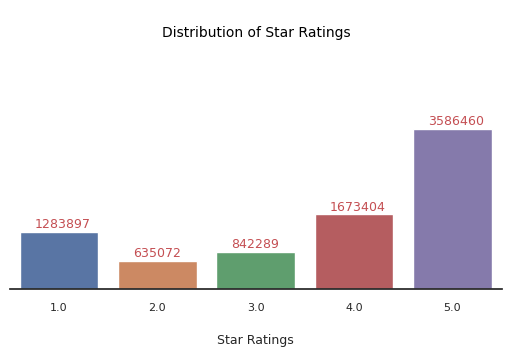

In [65]:
sns.set(style="white")
params = {'axes.spines.top':False, 'axes.spines.right': False, 'axes.spines.left': False, 
          'axes.labelsize' : 9, 'xtick.labelsize' : 8, 'ytick.labelsize' : 8}
matplotlib.rcParams.update(params)
fig = plt.figure(constrained_layout=True, figsize=(5, 2.4))
ax = fig.gca()
sns.countplot(reviews_dataset.stars, ax=ax)

counts=reviews_dataset.groupby('stars').count().text
for i, txt in enumerate(ax.get_xticklabels()):
    count = counts[float(txt.get_text())]
    ax.text(i-.25, count+100000, '{}'.format(count), fontdict={'fontsize': 9}, c='r')

ax.set_xlabel('\nStar Ratings')
ax.yaxis.set_visible(False)
matplotlib.rcParams.update(matplotlib.rcParamsDefault)
fig.suptitle('\nDistribution of Star Ratings', y=1.42, fontsize=10);
ax.set_xticklabels(labels=[lbl.get_text().title() for lbl in ax.get_xticklabels()]);


> Patrons rate establishments from 1 through 5 with 5 being the highest. The stars value will be able to provide the appropriate label to the sentiments.
However in lieu of the star ratings, this can be collated into: negative, neutral, positive. Reviews with 1 and 2 will fall into the negative, 3 into neutral, 4 and 5 into positive.

In [67]:
category_labels = [0, 1, 2]
cut_bins = [0, 2, 3, 5]
reviews_dataset['sentiment'] = pd.cut(reviews_dataset['stars'], bins=cut_bins, labels=category_labels)

# check the new structure
reviews_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8021122 entries, 0 to 8021121
Data columns (total 4 columns):
 #   Column       Dtype   
---  ------       -----   
 0   business_id  object  
 1   stars        float64 
 2   text         object  
 3   sentiment    category
dtypes: category(1), float64(1), object(2)
memory usage: 191.2+ MB


**Test the changes**.  All three queries should **not** return any values.

In [68]:
reviews_dataset.query('stars == 3 and (sentiment == 2 or sentiment == 0)')
reviews_dataset.query('stars < 3 and (sentiment == 1 or sentiment == 2)')
reviews_dataset.query('stars > 3 and (sentiment == 0 or sentiment == 1)')

,business_id,stars,text,sentiment


,business_id,stars,text,sentiment


,business_id,stars,text,sentiment


Review the new `sentiment` feature and distribution.

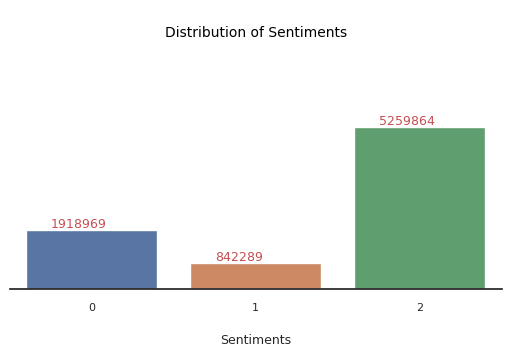

In [69]:
sns.set(style="white")
params = {'axes.spines.top':False, 'axes.spines.right': False, 'axes.spines.left': False, 
          'axes.labelsize' : 9, 'xtick.labelsize' : 8, 'ytick.labelsize' : 8}
matplotlib.rcParams.update(params)
fig = plt.figure(constrained_layout=True, figsize=(5, 2.4))
ax = fig.gca()
sns.countplot(reviews_dataset.sentiment, ax=ax)

counts=reviews_dataset.groupby('sentiment').count().text
for i, txt in enumerate(ax.get_xticklabels()):
    count = counts[int(txt.get_text())]
    ax.text(i-.25, count+100000, '{}'.format(count), fontdict={'fontsize': 9}, c='r')

ax.set_xlabel('\nSentiments')
ax.yaxis.set_visible(False)
matplotlib.rcParams.update(matplotlib.rcParamsDefault)
fig.suptitle('\nDistribution of Sentiments', y=1.42, fontsize=10);
ax.set_xticklabels(labels=[lbl.get_text().title() for lbl in ax.get_xticklabels()]);

> **Note :** Clearly there is an imbalance data.  The imbalance is addressed in a separate notebook.

Now that the sentiment feature has been created, there is no need for the stars feature and can be removed.

In [70]:
reviews_dataset.drop(['stars'], inplace=True, axis=1)

# Review changes made on this dataset.
df_info(reviews_dataset)


Shape : (8021122, 3)
Number of duplicates : 16063

              COLUMNS                DATA TYPE     HAS NULL    COUNTS    # UNIQUE

  1.  business_id                    str            False     8021122     209393
  2.  text                           str            False     8021122    7999488
  3.  sentiment                      int64          False     8021122          3


From above, `Number of duplicates`, it seems duplicates now appear in the dataset and needs to be investigated.

In [71]:
reviews_dataset[1000:12500][reviews_dataset[1000:12500].duplicated(subset=['text'], keep=False)]

,business_id,text,sentiment
1542,wjLgM9Ybe5shoUPRrGMmsQ,"Food is consistently good here. Portions are adequate, but the service can be slow.\n\nThe space is tight, and parking can be an issue in lawrenceville.",0
10470,wjLgM9Ybe5shoUPRrGMmsQ,"Food is consistently good here. Portions are adequate, but the service can be slow.\n\nThe space is tight, and parking can be an issue in lawrenceville.",0


> Selecting a subset/range of rows from the dataset, confirms that there are indeed duplicates.  It seems that after converting the JSON object into a dataframe, the `duplicated` function did not seem to work initially that's why it did not show up in the first round of review of the dataset.

Duplicates have no value and is a waste in resource so these need to be dropped.

In [72]:
reviews_dataset.drop_duplicates(inplace=True)

# Confirm duplicates no longer exist.
df_info(reviews_dataset)


Shape : (8005059, 3)
Number of duplicates : 0

              COLUMNS                DATA TYPE     HAS NULL    COUNTS    # UNIQUE

  1.  business_id                    str            False     8005059     209393
  2.  text                           str            False     8005059    7999488
  3.  sentiment                      int64          False     8005059          3


## Business Dataset

Reviews are from different type of establishments. This needs to be filtered down to only dine/drink type of establishments where our sentiment analysis will focus on.  To determine the type of establishments, the business dataset will need to be loaded where it contains features that can be keyed on for filtering.  

In [73]:
business_json = '../yelp_dataset/yelp_academic_dataset_business.json'
business_df = create_dataframe(business_json)
business_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 209393 entries, 0 to 209392
Data columns (total 14 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   business_id   209393 non-null  object 
 1   name          209393 non-null  object 
 2   address       209393 non-null  object 
 3   city          209393 non-null  object 
 4   state         209393 non-null  object 
 5   postal_code   209393 non-null  object 
 6   latitude      209393 non-null  float64
 7   longitude     209393 non-null  float64
 8   stars         209393 non-null  float64
 9   review_count  209393 non-null  int64  
 10  is_open       209393 non-null  int64  
 11  attributes    180348 non-null  object 
 12  categories    208869 non-null  object 
 13  hours         164550 non-null  object 
dtypes: float64(3), int64(2), object(9)
memory usage: 22.4+ MB


#### Restaurants Only

The `categories` feature holds the information for the type of establishment.  This will be used to filter the data.

In [74]:
# Business criteria: Restaurants, Bars, Pub, or wherever there's Food
eat_drink_business_df = business_df.query('not categories.isnull() and \
                  (categories.str.contains("Food") or categories.str.contains("Restaurants") \
                   or categories.str.contains("Bars") or categories.str.contains("Pub"))', 
                  engine='python')

eat_drink_business_df[['name', 'categories']].sample(5)

,name,categories
44064,Highland Farms,"Food, Grocery"
189036,Vince Seafood Restaurant & BBQ,"Chinese, Restaurants, Seafood"
176707,Taco Papi,"Mexican, Food, Tacos, Restaurants"
165585,Famous Dave's Bar-B-Que,"Barbeque, Restaurants, Food, Comfort Food, American (Traditional)"
69919,Lezzet Shawarma Falafel House,"Mediterranean, Falafel, Middle Eastern, Restaurants, Ethnic Food, Halal, Specialty Food, Food"


> Sample data of the type of establishments where customer reviews will come from.

<br>

#### Establishments that are still in business

The `is_open` feature of the business dataset indicates whether or not the establishment is still in business or not.

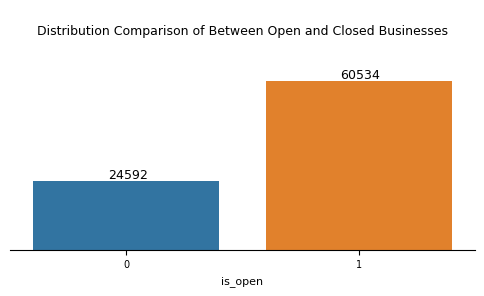

In [75]:
results = eat_drink_business_df.is_open
params = {'axes.spines.top':False, 'axes.spines.right': False, 'axes.spines.left': False, 'axes.labelsize' : 8, 
          'xtick.labelsize' : 7, 'axes.titlesize':9}
matplotlib.rcParams.update(params)
fig = plt.figure(constrained_layout=False, figsize=(6, 2.3))
ax = fig.gca()
ax.set_title('\nDistribution Comparison of Between Open and Closed Businesses\n\n')
p = sns.countplot(x=results, ax=ax)
ax.yaxis.set_visible(False)
counts=pd.Series(results).value_counts().sort_values(ascending=True)
for i, count in enumerate(counts):
    ax.text(i-.08, count+1000, '{}'.format(count), fontsize=9)

matplotlib.rcParams.update(matplotlib.rcParamsDefault);

> Proportion of businesses that are still open.

<br>

Filter the restaurants/bars that are still in business.

In [76]:
establishments_still_in_business = eat_drink_business_df.query('is_open == 1').business_id

reviews_dataset = reviews_dataset.query('business_id in @establishments_still_in_business')
df_info(reviews_dataset)


Shape : (4723973, 3)
Number of duplicates : 0

              COLUMNS                DATA TYPE     HAS NULL    COUNTS    # UNIQUE

  1.  business_id                    str            False     4723973      60534
  2.  text                           str            False     4723973    4722100
  3.  sentiment                      int64          False     4723973          3


In [77]:
len(reviews_dataset)/len(reviews_df)

0.588941671751159

> Considering only restaurant type establishments and those that are still in business, the reviews dataset is reduced to `59%` of its original size but with `4.7M` it is still a substantial size of data.

The `business_id` is no longer needed and can be removed.

In [78]:
reviews_dataset_2features = reviews_dataset.drop(['business_id'], axis=1, inplace=False)

# Verify structure
df_info(reviews_dataset_2features)


Shape : (4723973, 2)
Number of duplicates : 1417

              COLUMNS                DATA TYPE     HAS NULL    COUNTS    # UNIQUE

  1.  text                           str            False     4723973    4722100
  2.  sentiment                      int64          False     4723973          3


#### Persist changes and load dataset and review.

In [79]:
# Persist changes to a separate file.
reviews_dataset_2features.to_csv('../yelp_dataset/reviews_dataset.csv', index=False)

As a sanity check, load the data and review.

In [85]:
temp = pd.read_csv('../yelp_dataset/reviews_dataset.csv')
df_info(temp)


Shape : (4723973, 2)
Number of duplicates : 1417

              COLUMNS                DATA TYPE     HAS NULL    COUNTS    # UNIQUE

  1.  text                           str             True     4723972    4722099
  2.  sentiment                      int64          False     4723973          3


> Initially the dataset did not have any NA values but after re-loading, it now appears we do. This is because 'N/A' was interpreted as string during JSON conversion but is now recognized by pandas as a NA value after reloading the dataset.  

> In addition, duplicates also has appeared and needs to be removed.

Since NA values in text does not provide any meaningful data, these will have to be dropped.

In [86]:
# drop nulls
temp.dropna(inplace=True)

# drop duplicates
temp.drop_duplicates(inplace=True)

Verify change one more time and then persist the new updates.

In [87]:
df_info(temp)


Shape : (4722555, 2)
Number of duplicates : 0

              COLUMNS                DATA TYPE     HAS NULL    COUNTS    # UNIQUE

  1.  text                           str            False     4722555    4722099
  2.  sentiment                      int64          False     4722555          3


> Dataset looks much cleaner.

In [88]:
# Persist changes.
temp.to_csv('../yelp_dataset/reviews_dataset.csv', index=False)